In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hdbscan
import umap
import json
import time
import io
import re

In [6]:
name = "thewords"

In [7]:
# read the data in from csv
# create a string from the name
# read the data in from csv
# create a string from the name
filename = '../data/{name}.csv'.format(name=name)
data = pd.read_csv(filename , encoding='utf-8')

In [8]:
data.shape

(54057, 2)

In [9]:
data.head()

,word,count
0,the,23135851162
1,of,13151942776
2,and,12997637966
3,to,12136980858
4,in,8469404971


In [10]:
# np.savetxt("../data/reddit_dadjokes-text.csv", data["joke"].to_list(), delimiter=",", header="text", comments="", fmt='"%s"')
# export the joke column with the header "text" to a csv file
data["text"] = data["word"]
data["text"].to_csv("../data/{name}-text.csv".format(name=name), index=False, header=True, sep=',', quotechar='"', quoting=1, encoding='utf-8')


In [11]:
with open('../data/{name}-embeddings.json'.format(name=name), 'r') as f:
    metadata = json.load(f)

In [12]:
with open('../data/{name}-embeddings.bin'.format(name=name), 'rb') as f:
    embeddings = np.fromfile(f, dtype=np.float64)

In [13]:
#reshape the embeddings
embeddings = embeddings.reshape((len(metadata), metadata[0]["dimensions"]))

In [14]:
embeddings.shape

(54057, 1536)

In [42]:
# reduce dimensionality with umap
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.025,
    metric='cosine',
    random_state=42,
    n_components=2,
    verbose=True,
)

In [43]:
umap_embeddings = reducer.fit_transform(embeddings)

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.025, random_state=42, verbose=True)
Sun May 14 08:20:30 2023 Construct fuzzy simplicial set
Sun May 14 08:20:30 2023 Finding Nearest Neighbors
Sun May 14 08:20:30 2023 Building RP forest with 17 trees
Sun May 14 08:20:31 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	 6  /  16
	 7  /  16
	Stopping threshold met -- exiting after 7 iterations
Sun May 14 08:20:34 2023 Finished Nearest Neighbor Search
Sun May 14 08:20:34 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Sun May 14 08:20:53 2023 Finished embedding


In [44]:
umap_embeddings.shape

(54057, 2)

/var/folders/sx/rrvr6l_d5x1_g46jxlx5ypfc0000gn/T/ipykernel_93200/3739994091.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], s=1, cmap='Spectral')


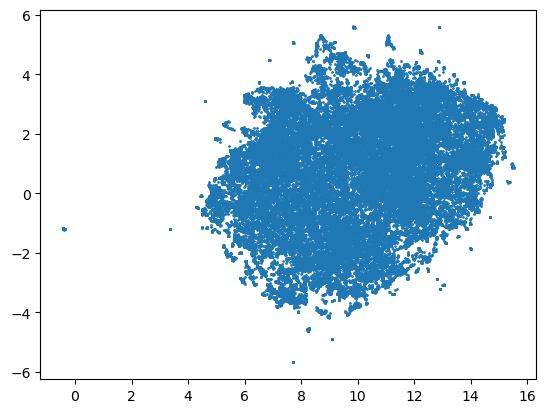

In [45]:
# plot embedding
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], s=1, cmap='Spectral')
plt.show()

In [24]:
#write embedding to csv file with header x,y
np.savetxt("../data/{name}-umap.csv".format(name=name), umap_embeddings, delimiter=",", header="x,y", comments='')

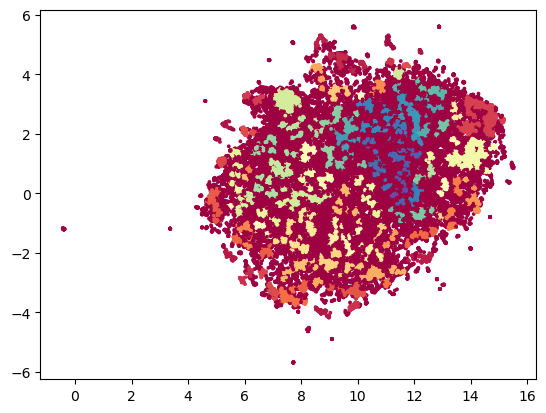

In [68]:
# Create an HDBSCAN instance with custom parameters
# cluster based on UMAP
clusterer = hdbscan.HDBSCAN(min_cluster_size=30, min_samples=30, metric='euclidean')
clusterer.fit(umap_embeddings)

cluster_labels = clusterer.labels_
np.unique(cluster_labels)
# plot embedding with cluster labels
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=cluster_labels, s=3, cmap='Spectral')
# Find the centroids of the non-noise clusters
unique_labels = np.unique(cluster_labels)



In [69]:
unique_labels

array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 17

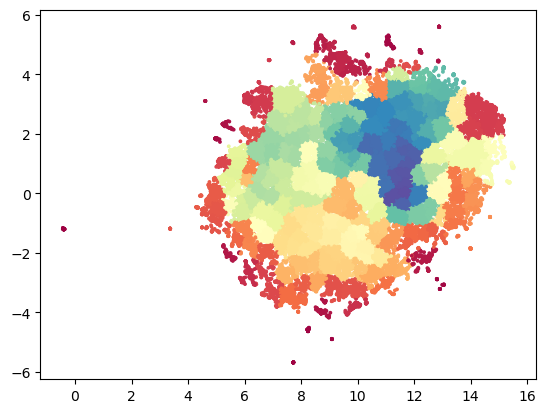

In [70]:
non_noise_labels = unique_labels[unique_labels != -1]
centroids = [umap_embeddings[cluster_labels == label].mean(axis=0) for label in non_noise_labels]
from scipy.spatial.distance import cdist
# Assign noise points to the closest cluster centroid
noise_points = umap_embeddings[cluster_labels == -1]
closest_centroid_indices = np.argmin(cdist(noise_points, centroids), axis=1)

# Update cluster_labels with the new assignments for noise points
noise_indices = np.where(cluster_labels == -1)[0]
new_assignments = [non_noise_labels[index] for index in closest_centroid_indices]
cluster_labels[noise_indices] = new_assignments
# plot embedding with cluster labels
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=cluster_labels, s=3, cmap='Spectral')
# write clusterer.labels_ to a csv file

In [71]:
np.savetxt("../data/{name}-hdbscan.csv".format(name=name), clusterer.labels_, delimiter=",", header="cluster", comments="")


In [ ]:
# select all of the blog entries in the same order as the blog_entry_embeddings table
# data = data[["id", "text"]].copy()
# data.shape

In [16]:

# # add the cluster labels to the dataframe
# data['cluster'] = clusterer.labels_
# # add x and y as columns to the dataframe from the embedding
# data['x'] = umap_embeddings[:, 0]
# data['y'] = umap_embeddings[:, 1]
# data.head()
# # write the dataframe to a csv file
# data.to_csv("../data/akhaliq_tweets-processed.csv", index=False)
